In [1]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
import scipy.stats

%matplotlib inline

In [2]:
# Experiments from "discriminance sampling" paper: MRF on 10x10 grid

In [7]:
import itertools

class GridMRF():
    ''' simple MRF with binary-valued variables and a grid of linear potentials'''
    
    def __init__(self,interaction_weights,external_fields):
        '''
        Parameters
        ----------
        interaction_weights : (N,N), numpy.ndarray
            interaction_weights[i,j] is the coupling strength between x[i] and x[j]
        external_fields : (N,), numpy.ndarray
            external_fields[i] is the 
        
        Attributes
        ----------
        Z : float
            exactly computed normalizing constant
        
        '''
        assert(interaction_weights.shape[0] == interaction_weights.shape[1])
        assert(interaction_weights.shape[0] == len(external_fields))
        
        self.interaction_weights = interaction_weights
        self.external_fields = external_fields
        
        # summing over ~2^20 states is easy, >2^25 is going to be sloooooww
        assert(len(external_fields) < 25) 
        self.Z = self.compute_exact_Z()
    
    def p_star(self,x):
        ''' unnormalized probability of x '''
        interaction_terms = x.T.dot(self.interaction_weights).dot(x)
        external_terms = x.T.dot(self.external_fields)
        return np.exp(interaction_terms+external_terms)
    
    def p(self,x):
        ''' normalized probability of x '''
        return self.p_star(x) / self.Z
    
    def compute_exact_Z(self):
        ''' sum over all x \in {0,1}^n_units '''
        n_units = len(self.external_fields)
        return sum([self.p_star(np.array(x)) for x in itertools.product(*[range(2)]*n_units)])

In [8]:
def generate_random_MRF(sigma_interaction, sigma_bias=0.1, n_units=10):
    ''' generate an GridMRF instance with gaussian couplings '''
    interaction_weights = npr.normal(loc=0,scale=sigma_interaction,size=(n_units,n_units))
    external_fields = npr.normal(loc=0,scale=sigma_bias,size=(n_units))
    mrf = GridMRF(interaction_weights,external_fields)
    return mrf

In [23]:
def sample_uniform_bit_string(length=20):
    return npr.randint(0,2,length)

In [10]:
n_units=20
mrf = generate_random_MRF(1.0,n_units=n_units)

In [11]:
x = sample_uniform_bit_string(n_units)

mrf.p_star(x),mrf.p(x)

(17.388857330329625, 2.2417975611112489e-11)

In [12]:
xs = np.array([x for x in itertools.product(*[range(2)]*n_units)])

values = [mrf.p(x) for x in xs]

In [13]:
values[0]

1.2892149947087716e-12

In [15]:
import scipy.stats

N = 1000
# draw from target distribution directly
rv = scipy.stats.rv_discrete(values=(range(len(values)),values))
target_samples = xs[rv.rvs(size=N)]

In [16]:
uniform_samples = npr.randint(0,2,(N,n_units))

In [17]:
target_sample_f = ([mrf.p_star(x) for x in target_samples])

In [18]:
mrf.Z

775665815325.00403

In [19]:
def uniform(x):
    return 1.0

# Z_uniform

In [20]:
import annealing_distributions
beta_schedule = np.linspace(0,1,50)
dists = [annealing_distributions.GeometricMean(uniform,mrf.p_star,beta) for beta in beta_schedule]

In [21]:
import transition_kernels

class Binary_RWMH():
    def __init__(self,target_f,fraction_to_mutate=0.1):
        self.target_f=target_f
        self.mut_rate = min(max(0,fraction_to_mutate),1) # constrain between 0 and 1
    
    def __call__(self,x,target_f):
        mutation_string = npr.rand(len(x))<(self.mut_rate/2.0) # 1.0 mutation rate = 0.5 chance of bit flip
        prop = 1*((x+mutation_string)>0) # roll 2's to 0s
        f_old = target_f(x)
        f_new = target_f(prop)
        if npr.rand() < 1.0*f_new/f_old:
            return prop
        return x
    
kernels = [Binary_RWMH(dist) for dist in dists]

In [24]:
import ais
Z_hat,_,_,ratios = ais.annealed_importance_sampling(sample_uniform_bit_string,kernels,dists)

In [25]:
xs.shape

(1048576, 20)

In [26]:
ratios.shape

(1000, 49)

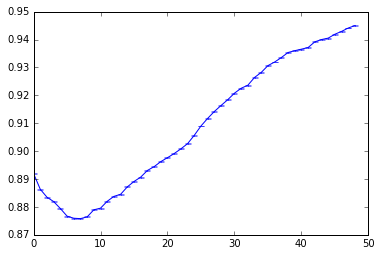

In [27]:
standard_error = ratios.std(0)/np.sqrt(len(xs))
plt.errorbar(range(len(ratios.T)),ratios.mean(0),yerr=standard_error);

In [28]:
# work
work = np.log(Z_hat)

# exponential average
exp_avg = lambda work:np.log(np.exp(work).mean())

In [29]:
log_Z_is = np.log(Z_hat.mean())
log_Z_is

9.8182229740394149

In [30]:
Z_true = mrf.Z/(2**n_units)
np.log(Z_true)

13.514044002819853

In [31]:
def draw_exact_target_sample():
    return xs[rv.rvs()]

In [32]:
rv.rvs()

252344

In [33]:
xs.shape

(1048576, 20)

In [34]:
Z_hat_,_,_,ratios_ = ais.annealed_importance_sampling(draw_exact_target_sample,kernels[::-1],dists[::-1])

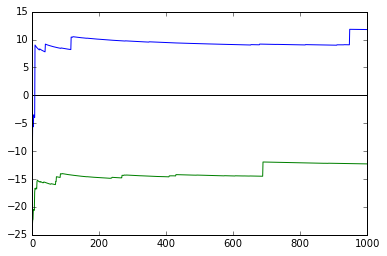

In [35]:
plt.plot(np.log(Z_hat))
plt.plot(np.log(Z_hat_))
plt.hlines(np.log(mrf.Z)/len(xs),0,len(Z_hat))

In [36]:
np.log(mrf.Z)/len(xs)

2.6108729948061713e-05

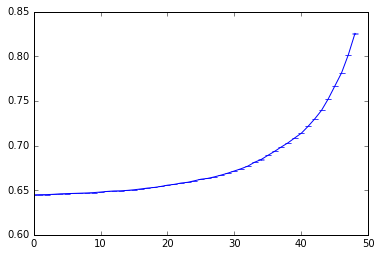

In [37]:
standard_error_ = ratios_.std(0)/np.sqrt(len(xs))
plt.errorbar(range(len(ratios_.T)),ratios_.mean(0),yerr=standard_error_);

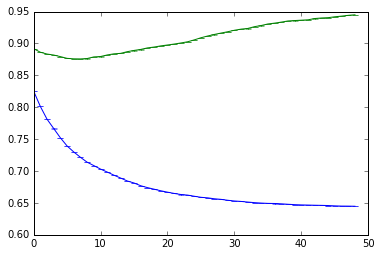

In [38]:
plt.errorbar(range(len(ratios_.T)),ratios_.mean(0)[::-1],yerr=standard_error_[::-1]);

plt.errorbar(range(len(ratios.T)),ratios.mean(0),yerr=standard_error);